# Customer segmentation project

Your are a datascientist working as a consultant for [Olist](https://olist.com/), a sales solution for online marketplaces.


Olist wants you to develop a customer segmentation that its marketing teams can use on a routine basis for their communicaion campaigns. 


You have an initial meeting with Olist's Marketing Director, Sophia, to better understand the need of the project. Here somme notes you took : 
- Olist marketing teams need an actionable description of the segmentation that allows them to thoroughly grasp its underlying logic (Notebook format).
- The [database](https://www.kaggle.com/olistbr/brazilian-ecommerce) contains information such as order history, products purchased, customer satisfaction comments, and location.
- The quality of the data is somewhat poor. The idea is to create the best possible features for making optimum use of them.
- Customer segmentation means understand the different types of users. Unsupervised algorithm is probably the best to use. 
- The segmentation needs to be robust: adding a few new customers to the database and creating a new segmentation using the same model should not result in totally different conclusions.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer,InterclusterDistance
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

### IMPORT CSVS

In [ ]:
# CUSTOMER
customers = pd.read_csv('../Data/Customer_segmentation/olist_customers_dataset.csv')
customers.name= "customers"

## SALES INFORMATION
# sellers dataset
sellers = pd.read_csv('../Data/Customer_segmentation/olist_sellers_dataset.csv')
sellers.name="sellers"
# order items dataset
items = pd.read_csv('../Data/Customer_segmentation/olist_order_items_dataset.csv')
items.name="order items"
# orders dataset
orders = pd.read_csv('../Data/Customer_segmentation/olist_orders_dataset.csv', parse_dates = ['order_purchase_timestamp','order_delivered_customer_date'])
orders.name='orders'
# orders reviews
reviews = pd.read_csv('../Data/Customer_segmentation/olist_order_reviews_dataset.csv')
reviews.name= "order reviews"
# product category
categories = pd.read_csv('../Data/Customer_segmentation/product_category_name_translation.csv')
# product
products = pd.read_csv('../Data/Customer_segmentation/olist_products_dataset.csv')
products.name="products"
# payments 
payments = pd.read_csv('../Data/Customer_segmentation/olist_order_payments_dataset.csv')
payments.name= "order payments"
# geolocalisation
geoloc = pd.read_csv('../Data/Customer_segmentation/olist_geolocation_dataset.csv')

## MARKETING FUNNEL
# leads dataset
mql = pd.read_csv('../Data/Customer_segmentation/olist_marketing_qualified_leads_dataset.csv')
# closed deals dataset
closed_deals = pd.read_csv('../Data/Customer_segmentation/olist_closed_deals_dataset.csv', parse_dates = ['won_date'])
geoloc.name= "geolocation"

## Understand and Clean Data Sets

In [ ]:
customers.head(2)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP


In [ ]:
sellers.head(2)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP


In [ ]:
items.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93


In [ ]:
orders.head(2)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00


In [ ]:
reviews.head(2)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13


In [ ]:
payments.head(2)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


In [ ]:
geoloc.head(2)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP


In [ ]:
categories.head(2)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories


In [ ]:
products.head(2)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0


In [ ]:
def exploreFrequencies(customers):
    print("{0:30} {1:25} {2:25}".format(customers.name, "unique values", "missing values"))
    for i in customers:
        print("{0:30} {1:20} {2:20}".format(i, customers[i].nunique(),customers[i].isna().sum()))
    print("------------------------------------")

In [ ]:
exploreFrequencies(customers)
exploreFrequencies(items)
exploreFrequencies(payments)
exploreFrequencies(reviews)
exploreFrequencies(orders)
exploreFrequencies(products)
exploreFrequencies(sellers)
exploreFrequencies(geoloc)

customers                      unique values             missing values           
customer_id                                   99441                    0
customer_unique_id                            96096                    0
customer_zip_code_prefix                      14994                    0
customer_city                                  4119                    0
customer_state                                   27                    0
------------------------------------
order items                    unique values             missing values           
order_id                                      98666                    0
order_item_id                                    21                    0
product_id                                    32951                    0
seller_id                                      3095                    0
shipping_limit_date                           93318                    0
price                                          5968                

Merge categories and product dataframes to use the English names

In [ ]:
# products_df contains 73 unique categories, while categories_df contains 71: that's why we use left, 
# for missing categories we keep the category name in Portuguese.
products = pd.merge(products, categories, on='product_category_name', how='left')
# Delete 'product_category_name' column
del products['product_category_name']
# Delete  the categories_df dataframe
del categories
# Rename the column
products.rename(columns={'product_category_name_english': 'product_category'}, inplace=True)

# 1. Join the different datasets into one dataset

TIPS : Use the function `merge` feel free to use the [doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html). 

Merge customers Dataset with the other datasets. Join the data by Customer ID

In [ ]:
customer_full = customers.merge(orders, on=["customer_id"], how='left')
print('customer_full shape:',customer_full.shape)
customer_full.head()

customer_full shape: (99441, 12)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


How many customers, orders, and orders per customer do we have?

In [ ]:
nb_customers = customer_full['customer_unique_id'].nunique()
nb_orders = customer_full.order_id.nunique()
print("number of customers:", nb_customers)
print("number of orders:   ", nb_orders)
print(f"number of orders per cusotmer: {nb_orders / nb_customers:.2f}")

number of customers: 96096
number of orders:    99441
number of orders per cusotmer: 1.03


Merge all other dataframes

In [ ]:
customer_full = customer_full.merge(items, on='order_id', how='left') # merge with items
customer_full = customer_full.merge(payments, on='order_id', how='left') # merge with payments
customer_full = customer_full.merge(products, on='product_id', how='left') # merge with products
customer_full = customer_full.merge(reviews[['order_id','review_score']], on='order_id', how='left') # merge with reviews score
customer_full = customer_full.merge(sellers, on='seller_id',how='left') # merge with sellers


print('customer_full shape:',customer_full.shape)
customer_full.head()

customer_full shape: (119151, 34)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category,review_score,seller_zip_code_prefix,seller_city,seller_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,1.0,8683.0,54.0,64.0,31.0,office_furniture,4,8577.0,itaquaquecetuba,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,...,3.0,10150.0,89.0,15.0,40.0,housewares,5,88303.0,itajai,SC
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,...,1.0,8267.0,52.0,52.0,17.0,office_furniture,5,8577.0,itaquaquecetuba,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,...,1.0,12160.0,56.0,51.0,28.0,office_furniture,5,8577.0,itaquaquecetuba,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,...,1.0,5200.0,45.0,15.0,35.0,home_confort,5,14940.0,ibitinga,SP


# 2. Understand, analyse and clean the dataset

TIPS : The quality of the dataset is not very good, don't hesitate to remove the variables with too many missing values. 

In [ ]:
customer_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119151 entries, 0 to 119150
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    119151 non-null  object        
 1   customer_unique_id             119151 non-null  object        
 2   customer_zip_code_prefix       119151 non-null  int64         
 3   customer_city                  119151 non-null  object        
 4   customer_state                 119151 non-null  object        
 5   order_id                       119151 non-null  object        
 6   order_status                   119151 non-null  object        
 7   order_purchase_timestamp       119151 non-null  datetime64[ns]
 8   order_approved_at              118974 non-null  object        
 9   order_delivered_carrier_date   117065 non-null  object        
 10  order_delivered_customer_date  115730 non-null  datetime64[ns]
 11  

In [ ]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(customer_full)
missing_values.head(20)

Your selected dataframe has 34 columns.
There are 24 columns that have missing values.


,Missing Values,% of Total Values
order_delivered_customer_date,3421,2.9
product_category,2567,2.2
product_photos_qty,2542,2.1
product_description_lenght,2542,2.1
product_name_lenght,2542,2.1
order_delivered_carrier_date,2086,1.8
product_height_cm,853,0.7
product_length_cm,853,0.7
product_weight_g,853,0.7
product_width_cm,853,0.7


### Analytics

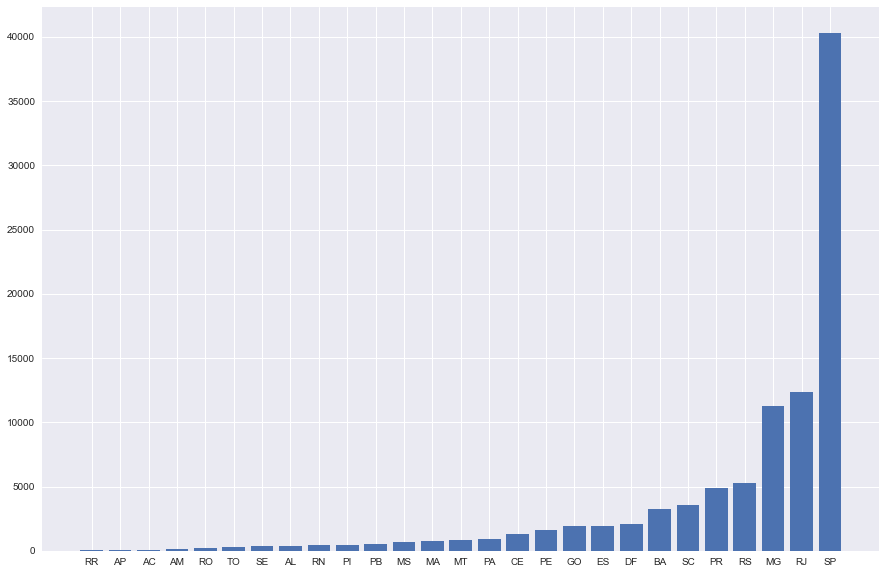

In [ ]:
customer_by_state = customer_full[['customer_unique_id', 'customer_state']].groupby('customer_state').nunique().reset_index()
customer_by_state = customer_by_state.sort_values(by=['customer_unique_id'])

plt.style.use('seaborn')
plt.figure(figsize=(15,10))
plt.bar(customer_by_state['customer_state'], customer_by_state['customer_unique_id'])
plt.show()

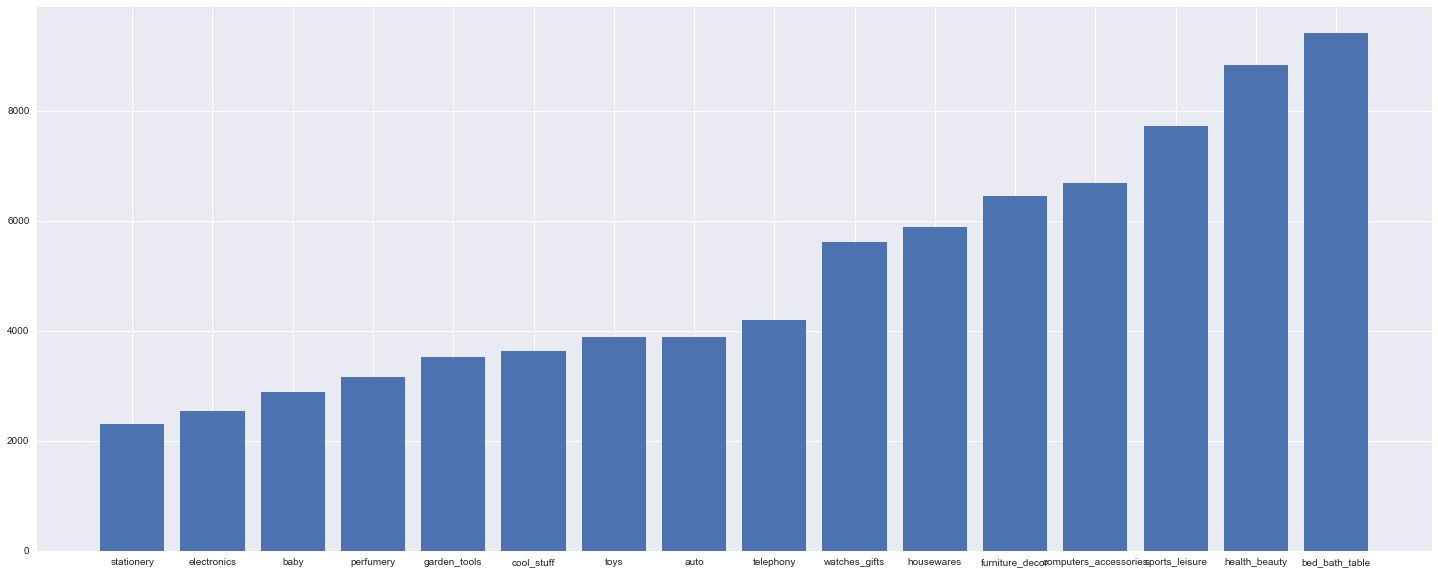

In [ ]:
nb_product = orders.merge(items,on=["order_id"], how='left').merge(products, on=["product_id"], how='left')
nb_product = nb_product[['customer_id', 'product_category']].groupby('product_category').nunique().reset_index().sort_values(by=['customer_id'])
plt.style.use('seaborn')
plt.figure(figsize=(25,10))
plt.bar(nb_product['product_category'][nb_product['customer_id']>2000], nb_product['customer_id'][nb_product['customer_id']>2000])
plt.show()

In [ ]:
nb_product.sort_values(by='customer_id',ascending=False).head(10)

,product_category,customer_id
7,bed_bath_table,9417
43,health_beauty,8836
65,sports_leisure,7720
15,computers_accessories,6689
39,furniture_decor,6449
49,housewares,5884
70,watches_gifts,5624
68,telephony,4199
5,auto,3897
69,toys,3886


In [ ]:
nb_product.customer_id.describe()

count      71.000000
mean     1380.239437
std      2272.863439
min         2.000000
25%        87.000000
50%       248.000000
75%      1491.500000
max      9417.000000
Name: customer_id, dtype: float64

In [ ]:
orders.order_status.value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [ ]:
items.price.describe()

count    112650.000000
mean        120.653739
std         183.633928
min           0.850000
25%          39.900000
50%          74.990000
75%         134.900000
max        6735.000000
Name: price, dtype: float64

In [ ]:
def plot_date_dist(df, feature_w_date):
    """plot the distribution of one feature w/ date"""

    df_tmp = pd.DataFrame(pd.DatetimeIndex(df[feature_w_date]).to_period('M'))
    tmp = df_tmp[feature_w_date].value_counts()
    
    df_tmp = pd.DataFrame({ 
                            feature_w_date : tmp.index,
                            'Quantity': tmp.values
                          })
    
    df_tmp = df_tmp.sort_values(by=feature_w_date)
    
    fig, ax = plt.subplots(figsize=(12,6))
    sns.set_color_codes("pastel")

    s = sns.barplot(ax = ax,
                    x = feature_w_date,
                    y = 'Quantity',
                    data = df_tmp)
    
    plt.xticks(rotation=45)
   
    plt.show();

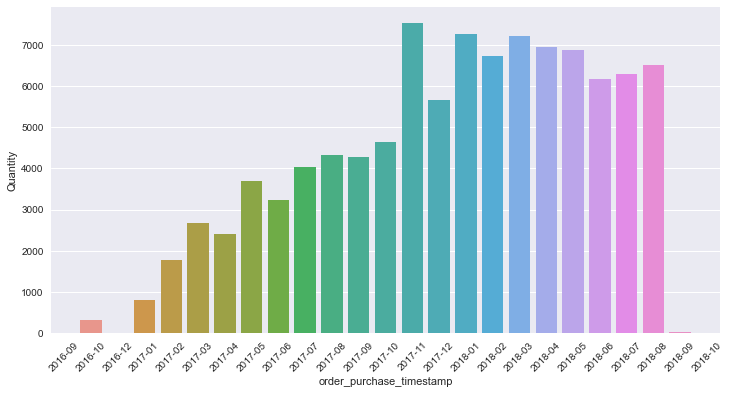

In [ ]:
plot_date_dist(orders, 'order_purchase_timestamp')

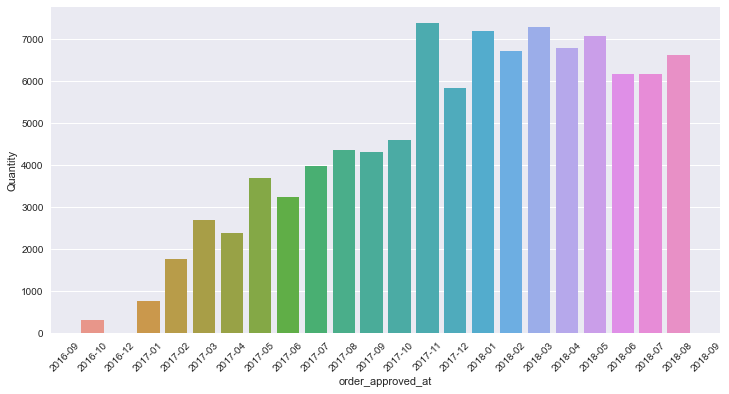

In [ ]:
plot_date_dist(orders, 'order_approved_at')

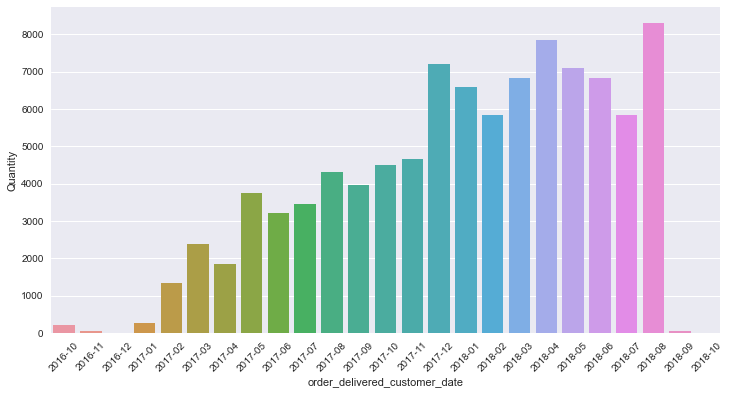

In [ ]:
plot_date_dist(orders, 'order_delivered_customer_date') 

In [ ]:
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [ ]:
reviews.review_score.describe()

count    100000.000000
mean          4.070890
std           1.359663
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: review_score, dtype: float64

# 3. Create variables recency, frequency and amount 

TIPS : Use only recent data to create your segmentation dataset (be careful not to cut off a trend, a sliding year of history is often a good choice).

### Recency
To calculate recency, we need to find out most recent purchase date of each customer and see for how many days they are inactive. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.


In [ ]:
#Create a dataframe with all unique customers
customerRFM = pd.DataFrame(customers['customer_unique_id']).drop_duplicates()

#Gets the max purchase date for each customer and create a dataframe with it
max_purchase = customer_full.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

# Create Rencency: we take our observation point as the max purchase date in our dataset
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
customerRFM = pd.merge(customerRFM, max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

customerRFM.head()

,customer_unique_id,Recency
0,861eff4711a542e4b93843c6dd7febb0,519
1,290c77bc529b7ac935b93aa66c333dc3,277
2,060e732b5b29e8181a18229c7b0b2b5e,151
3,259dac757896d24d7702b9acbbff3f3c,218
4,345ecd01c38d18a9036ed96c73b8d066,80


In [ ]:
customerRFM.Recency.describe()

count    96096.000000
mean       287.735691
std        153.414676
min          0.000000
25%        163.000000
50%        268.000000
75%        397.000000
max        772.000000
Name: Recency, dtype: float64

In [ ]:
customerRFM.shape

(96096, 2)

In [ ]:
max_purchase.shape

(96096, 3)

/Users/alexandrehanne/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


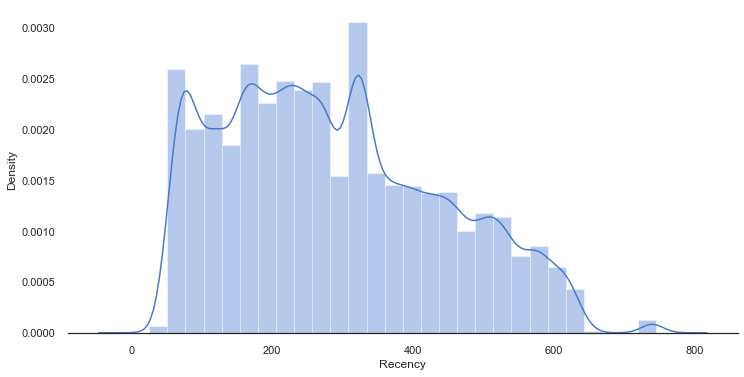

In [ ]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(customerRFM['Recency'], bins=30)
plt.show()

### Frequency
To create frequency clusters, i will need to find total number orders for each customer, after which i cango ahead and place them in various clusters

In [ ]:
#get order counts for each user and create a dataframe with it
frequency = customer_full.groupby('customer_unique_id').order_purchase_timestamp.nunique().reset_index()
frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
customerRFM = pd.merge(customerRFM, frequency, on='customer_unique_id')

In [ ]:
customerRFM.sort_values('Frequency',ascending=False).head(10)

,customer_unique_id,Recency,Frequency
14104,8d50f5eadf50201ccdcedfb9e2ac8455,57,17
5105,3e43e6105506432c953e165fb2acf44c,231,9
16760,6469f99c1f9dfae7733b25662e7f1782,111,7
6995,1b6c7548a2a1f9037c1fd3ddfed95f33,245,7
26099,ca77025e7201e3b30c44b472ff346268,138,7
19313,f0e310a6839dce9de1638e0fe5ab282a,195,6
28128,12f5d6e1cbf93dafd9dcc19095df0b3d,650,6
10553,63cfc61cee11cbe306bff5857d00bfe4,142,6
26957,de34b16117594161a6a89c50b289d35a,272,6
8855,dc813062e0fc23409cd255f7f53c7074,55,6


In [ ]:
customerRFM.Frequency.describe()

count    96096.000000
mean         1.031770
std          0.205447
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         17.000000
Name: Frequency, dtype: float64

In [ ]:
# Remove outliers - we see a customer with 17 orders
customerRFM.drop(customerRFM.loc[customerRFM['Frequency']>10].index,inplace=True)

### Monetary
Let’s see how our customer base looks like when I cluster them based on revenue. I will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [ ]:
revenue = customers.merge(orders, on=["customer_id"], how='left').merge(payments, on=["order_id"], how='left').groupby('customer_unique_id').payment_value.sum().reset_index()
revenue.columns = ['customer_unique_id','Monetary']

#merge it with our RFM dataframe
customerRFM = pd.merge(customerRFM, revenue, on='customer_unique_id')

customerRFM.head()

,customer_unique_id,Recency,Frequency,Monetary
0,861eff4711a542e4b93843c6dd7febb0,519,1,146.87
1,290c77bc529b7ac935b93aa66c333dc3,277,1,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,151,1,157.73
3,259dac757896d24d7702b9acbbff3f3c,218,1,173.30
4,345ecd01c38d18a9036ed96c73b8d066,80,1,252.25


In [ ]:
customerRFM.Monetary.describe()

count    96095.000000
mean       166.584572
std        231.416514
min          0.000000
25%         63.120000
50%        108.000000
75%        183.530000
max      13664.080000
Name: Monetary, dtype: float64

/Users/alexandrehanne/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


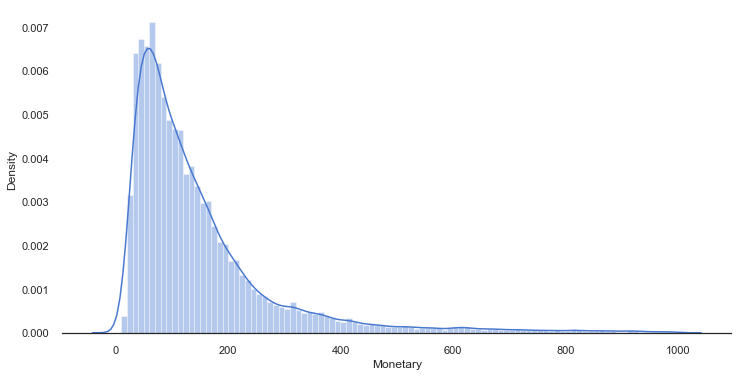

In [ ]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(customerRFM[customerRFM['Monetary'].between(0,1000)]['Monetary'], bins=100)
plt.show()

In [ ]:
# Remove customer with 0 monetary values. Should be errors in the orders.

In [ ]:
customerRFM.drop(customerRFM.loc[customerRFM['Monetary']==0].index,inplace=True)

### RFM Table

In [ ]:
customerRFM.head()

,customer_unique_id,Recency,Frequency,Monetary
0,861eff4711a542e4b93843c6dd7febb0,519,1,146.87
1,290c77bc529b7ac935b93aa66c333dc3,277,1,335.48
2,060e732b5b29e8181a18229c7b0b2b5e,151,1,157.73
3,259dac757896d24d7702b9acbbff3f3c,218,1,173.30
4,345ecd01c38d18a9036ed96c73b8d066,80,1,252.25


In [ ]:
customerRFM.describe()

,Recency,Frequency,Monetary
count,96092.000000,96092.000000,96092.000000
mean,287.738168,1.031605,166.589773
std,153.404503,0.198888,231.418254
min,0.000000,1.000000,9.590000
25%,163.000000,1.000000,63.127500
50%,268.000000,1.000000,108.000000
75%,397.000000,1.000000,183.530000
max,772.000000,9.000000,13664.080000


#### Add RFM Score

In [ ]:
'''args : x = value, p = recency, monetary_value, frequency, d = quartiles dict'''
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
'''args :x = valeur, p = recency, monetary_value, frequency, k = quartiles dict'''
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [ ]:
quantiles = customerRFM.quantile(q=[0.25,
                                       0.5,
                                       0.75])

customerRFM['R_Quartile'] = customerRFM['Recency'].apply(RScore, args=('Recency',quantiles,))
customerRFM['F_Quartile'] = customerRFM['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
customerRFM['M_Quartile'] = customerRFM['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

customerRFM['RFMSegment'] = customerRFM.R_Quartile.map(str) \
                             + customerRFM.F_Quartile.map(str) \
                             + customerRFM.M_Quartile.map(str)

customerRFM['RFMScore'] = customerRFM[['R_Quartile', 'F_Quartile', 'M_Quartile']].sum(axis = 1)

# assign labels from total score
score_labels = ['Std Customers', 'Silver', 'Gold','Prenium']
score_groups = pd.qcut(customerRFM.RFMScore, q = 4, labels = score_labels)
customerRFM['RFM_Level'] = score_groups.values

In [ ]:
customerRFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMSegment,RFMScore,RFM_Level
0,861eff4711a542e4b93843c6dd7febb0,519,1,146.87,1,1,3,113,5,Std Customers
1,290c77bc529b7ac935b93aa66c333dc3,277,1,335.48,2,1,4,214,7,Gold
2,060e732b5b29e8181a18229c7b0b2b5e,151,1,157.73,4,1,3,413,8,Prenium
3,259dac757896d24d7702b9acbbff3f3c,218,1,173.30,3,1,3,313,7,Gold
4,345ecd01c38d18a9036ed96c73b8d066,80,1,252.25,4,1,4,414,9,Prenium


In [ ]:
print("Top clients (PREMIUM): ",len(customerRFM[customerRFM['RFM_Level']=='Prenium']))
print('GOLD: ',len(customerRFM[(customerRFM['RFM_Level']=='Gold')]))
print("SILVER: ",len(customerRFM[customerRFM['RFM_Level']=='Silver']))
print("STANDARD CUSTOMER: ",len(customerRFM[customerRFM['RFM_Level']=='Std Customers']))

Top clients (PREMIUM):  19850
GOLD:  17256
SILVER:  23072
STANDARD CUSTOMER:  35914


# 4 Choose the variables of interest in your dataset and create your segmentation dataset

TIPS : Don't use all your variables for your segmentation, use only the varaibles that you think are the most relevant to your marketing team.

In [ ]:
customerRFM.head()

,customer_unique_id,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMSegment,RFMScore,RFM_Level
0,861eff4711a542e4b93843c6dd7febb0,519,1,146.87,1,1,3,113,5,Std Customers
1,290c77bc529b7ac935b93aa66c333dc3,277,1,335.48,2,1,4,214,7,Gold
2,060e732b5b29e8181a18229c7b0b2b5e,151,1,157.73,4,1,3,413,8,Prenium
3,259dac757896d24d7702b9acbbff3f3c,218,1,173.30,3,1,3,313,7,Gold
4,345ecd01c38d18a9036ed96c73b8d066,80,1,252.25,4,1,4,414,9,Prenium


### Add review scores to assess satisfactions

In [ ]:
satisfaction = customers.merge(orders, on=["customer_id"], how='left').merge(reviews, on=["order_id"], how='left').groupby('customer_unique_id').review_score.mean().reset_index()
satisfaction.columns = ['customer_unique_id','Satisfaction']

#merge it with our RFM dataframe
customerSeg = pd.merge(customerRFM[['customer_unique_id','Recency','Frequency','Monetary','RFMScore']], satisfaction, on='customer_unique_id')

customerSeg.head()

,customer_unique_id,Recency,Frequency,Monetary,RFMScore,Satisfaction
0,861eff4711a542e4b93843c6dd7febb0,519,1,146.87,5,4.0
1,290c77bc529b7ac935b93aa66c333dc3,277,1,335.48,7,5.0
2,060e732b5b29e8181a18229c7b0b2b5e,151,1,157.73,8,5.0
3,259dac757896d24d7702b9acbbff3f3c,218,1,173.30,7,5.0
4,345ecd01c38d18a9036ed96c73b8d066,80,1,252.25,9,5.0


In [ ]:
customerSeg.Satisfaction.describe()

count    96092.000000
mean         4.069603
std          1.353396
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Satisfaction, dtype: float64

### Use only recent data to train your segmentation algorithm to capture the most interesting behaviors 

In [ ]:
customerSeg = customerSeg[customerSeg.Recency<=365].copy()

# 5 Test Two different segmentation algorithms

TIPS : Make maximum use of the code seen in the last TPs. You can also use [others algorithms](https://scikit-learn.org/stable/modules/clustering.html) that sklearn offers. 

In [ ]:
std = StandardScaler()
x_std = std.fit_transform(customerSeg.drop(labels='customer_unique_id',axis=1))

### Model KMeans

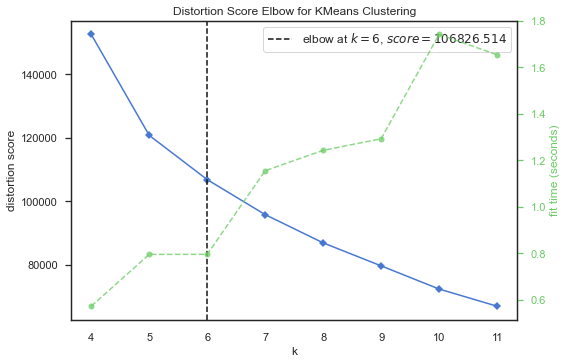

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
Kmodel = KMeans()
Kvisualizer = KElbowVisualizer(Kmodel, k=(4,12))

Kvisualizer.fit(x_std)        # Fit the data to the visualizer
Kvisualizer.show()

In [ ]:
Kmodelopt = KMeans(n_clusters=6)
Kmodelopt.fit(x_std)

predict_cluster = Kmodelopt.predict(x_std)

KMeans_db_score = davies_bouldin_score(x_std, predict_cluster)
KMeans_s_score = silhouette_score(x_std, predict_cluster)

In [ ]:
print('KMeans Davis Bouldin Score:', KMeans_db_score) # better to tend to 0
print('KMeans Silhouette Score:', KMeans_s_score) # better to tend to 1

KMeans Davis Bouldin Score: 0.9527188380191792
KMeans Silhouette Score: 0.325627678122073


### DBSCAN Model

In [ ]:
model_db = DBSCAN(eps=0.9)
db_predicted = model_db.fit_predict(x_std)

In [ ]:
labels = model_db.labels_
from collections import Counter
Counter(labels)

Counter({0: 65594, 1: 1872, 2: 109, -1: 121, 4: 7, 3: 8, 5: 14, 6: 6})

In [ ]:
dbscan_db_score = davies_bouldin_score(x_std, db_predicted)
dbscan_s_score = silhouette_score(x_std, db_predicted)

In [ ]:
print('DBSCAN Davis Bouldin Score:', dbscan_db_score) # better to tend to 0
print('DBSCAN Silhouette Score:', dbscan_s_score) # better to tend to 1

DBSCAN Davis Bouldin Score: 1.2345468585161745
DBSCAN Silhouette Score: 0.5961463694606083


In [ ]:
db = DBSCAN(eps=0.8)
db_predicted = db.fit_predict(x_std)
labels = db.labels_
from collections import Counter
Counter(labels)

Counter({0: 65581, 1: 1863, 2: 104, -1: 152, 5: 7, 3: 8, 6: 6, 4: 10})

In [ ]:
dbscan_db_score = davies_bouldin_score(x_std, db_predicted)
dbscan_s_score = silhouette_score(x_std, db_predicted)
print('DBSCAN Davis Bouldin Score:', dbscan_db_score) # better to tend to 0
print('DBSCAN Silhouette Score:', dbscan_s_score) # better to tend to 1

DBSCAN Davis Bouldin Score: 1.4348075265159768
DBSCAN Silhouette Score: 0.5934326567263407


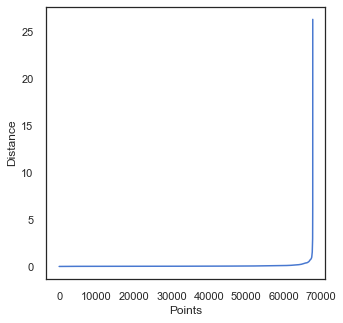

In [ ]:
from sklearn.neighbors import NearestNeighbors
nearest_neighbors = NearestNeighbors(n_neighbors=101)
neighbors = nearest_neighbors.fit(x_std)
distances, indices = neighbors.kneighbors(x_std)
distances = np.sort(distances[:,10], axis=0)
fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")
plt.savefig("Distance_curve.png", dpi=300)

The DBSCAN algorithm is not suitable here. Indeed, when counting the number of customers in each clusters, we see that one to four clusters are taking into account 95% of the all database because most customers are very similar (see graph above). Furthermore the DB score and silhouette score are less good than for the Kmeans algorithm. 

# 6 Choose the optimal number of clusters

TIPS : The goal is to create a segmentation that your marketing team can use, so don't use too many clusters.

*Kmeans has better DB and Silhouette score, we will use it as clustering algorrithm. Yet, having 7 clusters can be challenging to work with for the marketing, especially when the huge majority of our customers are similar. So, we will reduce the number of clusters to 4.*

In [ ]:
Kmodelopt = KMeans(n_clusters=4)
Kmodelopt.fit(x_std)

cluster_map = pd.DataFrame()
cluster_map['data_index'] = customerSeg.index.values
cluster_map['cluster'] = Kmodelopt.labels_


#predict_cluster = Kmodelopt.predict(x_std)

In [ ]:
customerSeg['cluster'] = Kmodelopt.labels_

In [ ]:
customerSeg.head(10)

,customer_unique_id,Recency,Frequency,Monetary,RFMScore,Satisfaction,cluster
1,290c77bc529b7ac935b93aa66c333dc3,277,1,335.48,7,5.0,3
2,060e732b5b29e8181a18229c7b0b2b5e,151,1,157.73,8,5.0,2
3,259dac757896d24d7702b9acbbff3f3c,218,1,173.30,7,5.0,2
4,345ecd01c38d18a9036ed96c73b8d066,80,1,252.25,9,5.0,2
6,addec96d2e059c80c30fe6871d30d177,240,1,22.77,5,5.0,3
7,57b2a98a409812fe9618067b6b8ebe4f,334,1,36.01,4,3.0,3
8,1175e95fb47ddff9de6b2b06188f7e0d,272,2,83.19,8,5.0,0
9,9afe194fb833f79e300e37e580171f22,282,1,122.47,6,5.0,3
10,2a7745e1ed516b289ed9b29c7d0539a5,324,1,40.40,4,5.0,3
11,2a46fb94aef5cbeeb850418118cee090,252,1,153.13,7,5.0,3


In [ ]:
customerSeg.cluster.value_counts()

2    28070
3    25840
1    11739
0     2082
Name: cluster, dtype: int64

# 7 Visualize your data using PCa and coloring the data according to their class

TIPS : Make maximum use of the code seen in the last TPs.

In [ ]:
pca = PCA()
pca.fit(x_std)

PCA()

In [ ]:
print(pca.explained_variance_ratio_)

[0.37168277 0.22209657 0.18799097 0.1682542  0.04997548]


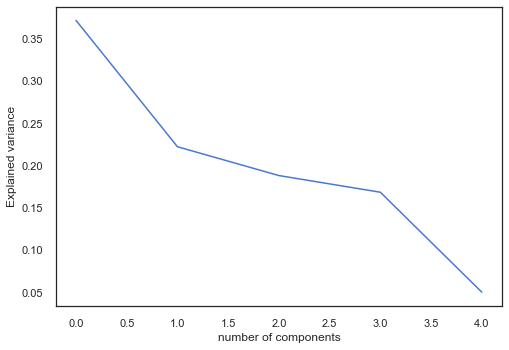

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('Explained variance')
plt.show()

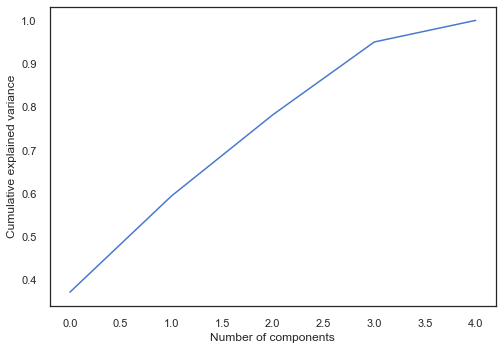

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

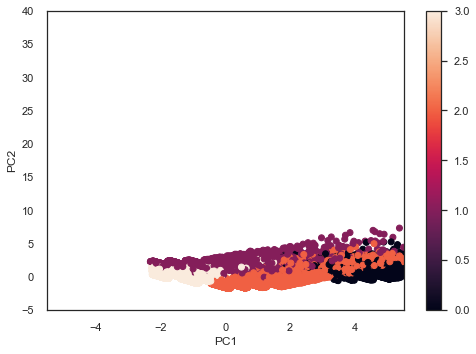

In [ ]:
### Start of your code

#  project X on the principal components
X_projected = pca.transform(x_std)

### End of your code

# display each observation
plt.scatter(X_projected[:, 0], X_projected[:, 1],
    # color using the 'Rank' variable
    c=customerSeg.get('cluster'))

plt.xlim([-5.5, 5.5])
plt.ylim([-5, 40])
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

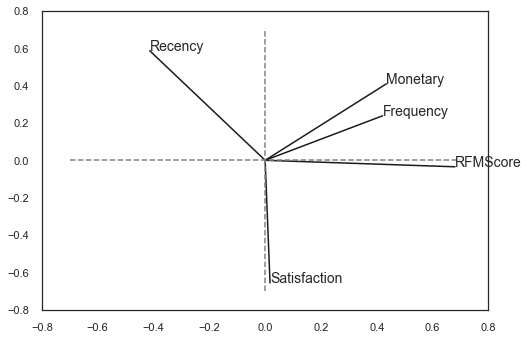

In [ ]:
customerdrop = customerSeg.drop(['customer_unique_id', 'cluster'], axis=1)
pcs = pca.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Display a segment from the origin to the point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Display the name (data.columns[i]) of the performance
    plt.text(x, y, customerSeg.drop(labels='customer_unique_id',axis=1).columns[i], fontsize='14')

# Display a horizontal line y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Display a vertical line x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.8,0.8])
plt.ylim([-0.8,0.8])


plt.show()

*The PCA analysis won't be the most pertinent in our strategy. Indeed, the variable of the dataset are not descrpitive enough and we manage to reduce the number of variables to be used to 5. A PCA analysis is used when a high number of variables is take into account and when this number has to be reduced, which is finally not the case here.*

# 8 Analyse your customer clusters and find different behaviors

TIPS : You can use additional variables for determining the behavior of your segments than those used for segmentation.

*We will analyze our 4 clusters from the Kmeans analyse. We will look at RFM score, states and mean review score.*

**Alex ajoute State column à customerSeg**

In [ ]:
customerSeg[customerSeg.cluster == 0].describe()

,Recency,Frequency,Monetary,RFMScore,Satisfaction,cluster
count,2082.000000,2082.000000,2082.000000,2082.000000,2082.000000,2082.0
mean,198.478386,2.115754,327.245941,10.650817,4.104272,0.0
std,89.637525,0.469698,415.044100,1.100248,1.122469,0.0
min,0.000000,1.000000,34.970000,7.000000,1.000000,0.0
25%,123.250000,2.000000,150.752500,10.000000,3.500000,0.0
50%,196.000000,2.000000,230.960000,11.000000,4.500000,0.0
75%,271.000000,2.000000,369.592500,12.000000,5.000000,0.0
max,365.000000,9.000000,9553.020000,12.000000,5.000000,0.0


In [ ]:
customerSeg[customerSeg.cluster == 1].describe()

,Recency,Frequency,Monetary,RFMScore,Satisfaction,cluster
count,11739.000000,11739.0,11739.000000,11739.000000,11739.000000,11739.0
mean,223.274981,1.0,197.740401,6.648437,1.441108,1.0
std,79.301719,0.0,259.100479,1.257186,0.722836,0.0
min,0.000000,1.0,13.780000,4.000000,1.000000,1.0
25%,170.000000,1.0,73.810000,6.000000,1.000000,1.0
50%,228.000000,1.0,129.270000,7.000000,1.000000,1.0
75%,284.000000,1.0,215.050000,8.000000,2.000000,1.0
max,365.000000,1.0,6081.540000,9.000000,4.000000,1.0


In [ ]:
customerSeg[customerSeg.cluster == 2].describe()

,Recency,Frequency,Monetary,RFMScore,Satisfaction,cluster
count,28070.000000,28070.0,28070.000000,28070.000000,28070.000000,28070.0
mean,131.641361,1.0,192.762479,7.464731,4.646711,2.0
std,53.989632,0.0,249.212846,1.010483,0.602947,0.0
min,47.000000,1.0,9.590000,6.000000,2.000000,2.0
25%,84.000000,1.0,74.400000,7.000000,4.000000,2.0
50%,126.000000,1.0,130.140000,8.000000,5.000000,2.0
75%,167.000000,1.0,208.787500,8.000000,5.000000,2.0
max,364.000000,1.0,4681.780000,9.000000,5.000000,2.0


In [ ]:
customerSeg[customerSeg.cluster == 3].describe()

,Recency,Frequency,Monetary,RFMScore,Satisfaction,cluster
count,25840.000000,25840.0,25840.000000,25840.000000,25840.000000,25840.0
mean,278.777825,1.0,110.042107,5.485372,4.584830,3.0
std,52.555433,0.0,107.429815,0.968933,0.651852,0.0
min,164.000000,1.0,11.630000,4.000000,2.000000,3.0
25%,239.000000,1.0,50.750000,5.000000,4.000000,3.0
50%,282.000000,1.0,79.560000,5.000000,5.000000,3.0
75%,324.000000,1.0,132.050000,6.000000,5.000000,3.0
max,365.000000,1.0,1482.420000,7.000000,5.000000,3.0


/Users/alexandrehanne/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/alexandrehanne/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/alexandrehanne/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


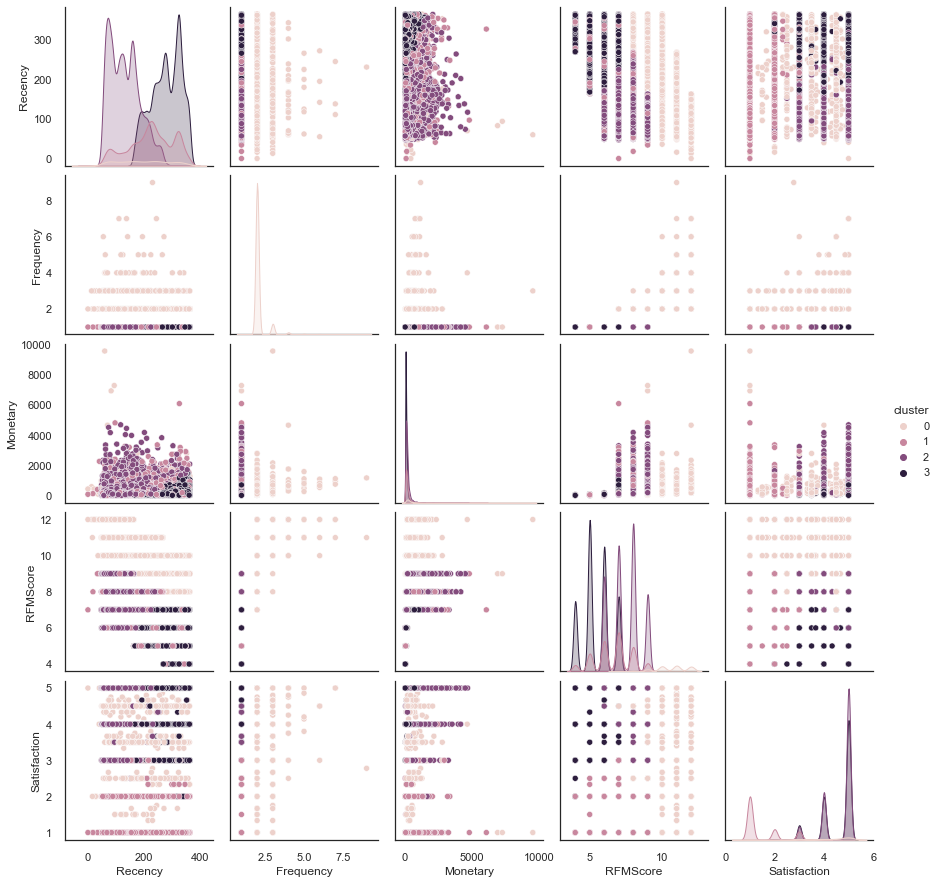

In [ ]:
sns.pairplot(data=customerSeg, hue="cluster")

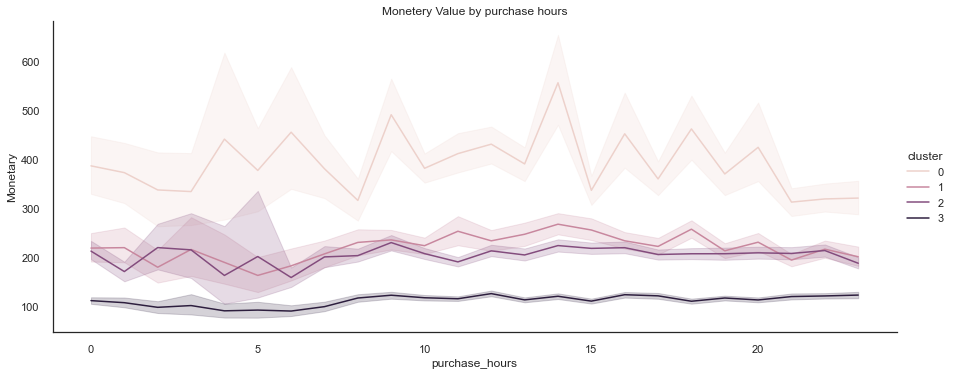

In [ ]:
hour_buying = customerSeg.merge(customer_full[['customer_unique_id','order_id','order_purchase_timestamp','payment_type','price','product_category','freight_value']],on=['customer_unique_id'],how='left')
hour_buying['purchase_hours'] = hour_buying.order_purchase_timestamp.dt.hour
sns.relplot(
    data=hour_buying, kind="line",
    x="purchase_hours", y="Monetary", aspect=2.5,
    hue="cluster",facet_kws=dict(sharex=False),
)
plt.title('Monetery value by purchase hours')
plt.show()

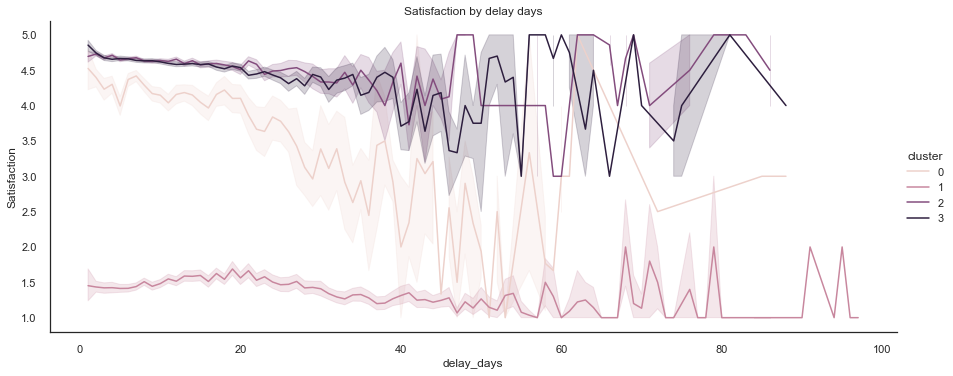

''

In [ ]:
shipping_delay = hour_buying.merge(orders[['order_id','order_delivered_customer_date']],on=['order_id'],how='left')
# Calculates the difference between purcahse date date and delivery 
shipping_delay['delay_days'] =  shipping_delay.order_delivered_customer_date - shipping_delay.order_purchase_timestamp
# converts the difference in terms of days
shipping_delay['delay_days'] = round(shipping_delay['delay_days'] / np.timedelta64(1,'D'))
sns.relplot(
    data=shipping_delay[shipping_delay.delay_days<100], kind="line",
    x="delay_days", y="Satisfaction",aspect=2.5,
    hue="cluster",facet_kws=dict(sharex=False),
)
plt.title('Satisfaction by delay days')
plt.show()
;

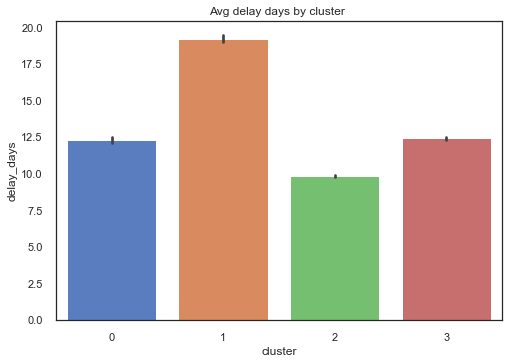

In [ ]:
sns.barplot(x="cluster", y="delay_days", data=shipping_delay)
plt.title('Avg delay days by cluster ')
plt.show()

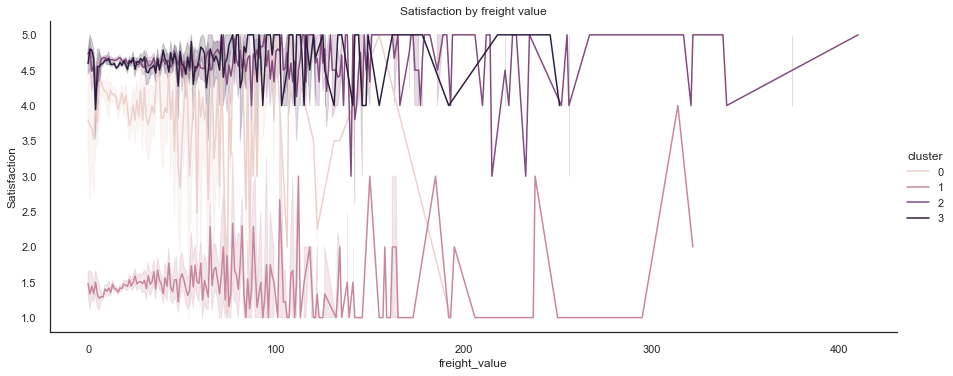

In [ ]:
shipping_delay['freight_value'] = round(shipping_delay['freight_value'])
sns.relplot(
    data=shipping_delay, kind="line",
    x="freight_value", y="Satisfaction",aspect=2.5,
    hue="cluster",facet_kws=dict(sharex=False),
)
plt.title('Satisfaction by freight value')
plt.show();

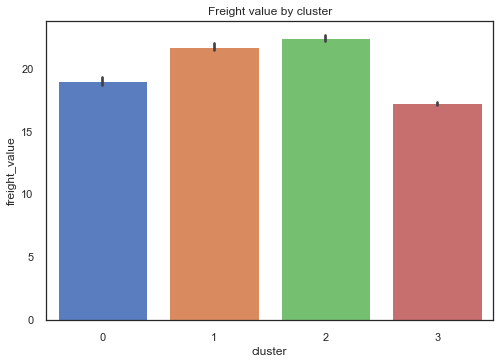

In [ ]:
sns.barplot(x="cluster", y="freight_value", data=shipping_delay)
plt.title('Freight value by cluster')
plt.show()

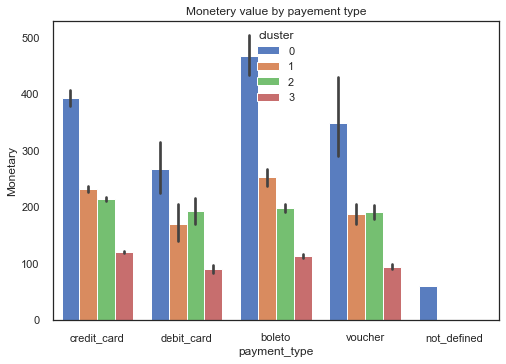

In [ ]:
sns.barplot(x="payment_type", y="Monetary", hue="cluster", data=shipping_delay)
plt.title('Monetery value by payement type')
plt.show()